In [1]:
import numpy as np
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt

from data.get_results import get_results
from likelihood import get_kernel
from acquisitions import ucb, generate, likelihood

 E:\Program_Files\Anaconda\envs\testpymc3\lib\site-packages\h5py\__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: (np.array(functions_dict[f]) - np.mean(functions_dict[f])) / np.std(functions_dict[f]) for f in function_names}

### Test if parameters of UCB model can be recovered:

In [3]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']

#### Balanced explore/exploit

In [4]:
X, clusters = generate(ucb, {'explore': [.5]}, neg_quad_kern, neg_quad, 20, 60, 1, [1.])
actions = X[:,:,2].argmax(axis = 2)

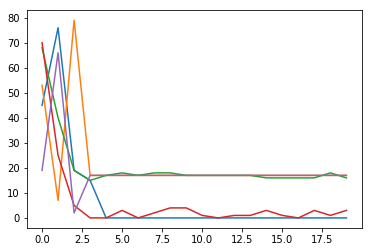

In [5]:
plt.plot(actions[:5].T)

In [6]:
with pm.Model() as model:
    explore = pm.Beta('explore', 1., 1.)
    obs = pm.Potential('obs', likelihood(X, ucb, {'explore': explore}, 1, [1.]))

In [7]:
with model:
    trace = pm.sample(600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [explore]
Sampling 4 chains: 100%|██████████| 4400/4400 [00:11<00:00, 380.01draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CF000BDD68>,
      dtype=object)

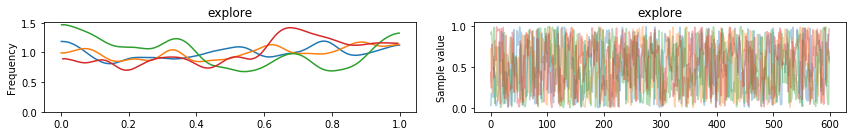

In [8]:
pm.traceplot(trace)

In [9]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = 0.028155, ||grad|| = 0.0050361: 100%|██████████| 5/5 [00:00<00:00, 626.67it/s]


{'explore_logodds__': array(-21.), 'explore': array(7.58256042e-10)}

In [10]:
print("p(X | pure explore) = " + str((likelihood(X, ucb, {'explore': 1.}, 1, [1.]))))
print("p(X | explore/exploit) = " + str((likelihood(X, ucb, {'explore': .5}, 1, [1.]))))
print("p(X | pure exploit) = " + str((likelihood(X, ucb, {'explore': .0}, 1, [1.]))))

p(X | pure explore) = 0.022958652732791646
p(X | explore/exploit) = 0.028154824661744838
p(X | pure exploit) = 0.19158707932578184


#### Pure explore

In [11]:
X, clusters = generate(ucb, {'explore': [1.]}, neg_quad_kern, neg_quad, 20, 60, 1, [1.])
actions = X[:,:,2].argmax(axis = 2)

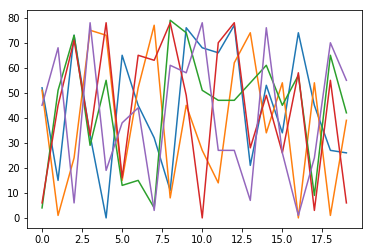

In [12]:
plt.plot(actions[:5].T)

In [13]:
with pm.Model() as model:
    explore = pm.Beta('explore', 1., 1.)
    obs = pm.Potential('obs', likelihood(X, ucb, {'explore': explore}, 1, [1.]))

In [14]:
with model:
    trace = pm.sample(600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [explore]
Sampling 4 chains: 100%|██████████| 4400/4400 [00:11<00:00, 399.98draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CF003C0828>,
      dtype=object)

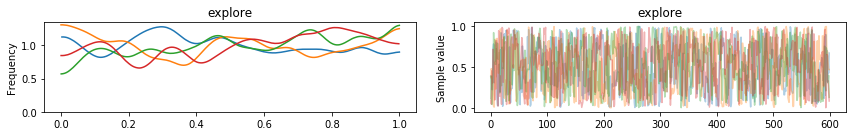

In [15]:
pm.traceplot(trace)

In [16]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = 0.018455, ||grad|| = 0.0032815: 100%|██████████| 11/11 [00:00<00:00, 479.05it/s]


{'explore_logodds__': array(6.52904296), 'explore': array(0.99854173)}

In [17]:
print("p(X | pure explore) = " + str((likelihood(X, ucb, {'explore': 1.}, 1, [1.]))))
print("p(X | explore/exploit) = " + str((likelihood(X, ucb, {'explore': .5}, 1, [1.]))))
print("p(X | pure exploit) = " + str((likelihood(X, ucb, {'explore': .0}, 1, [1.]))))

p(X | pure explore) = 0.021864610690518697
p(X | explore/exploit) = 0.018454507428269575
p(X | pure exploit) = -0.06853269225038806


#### Pure exploit

In [18]:
X, clusters = generate(ucb, {'explore': [0.]}, neg_quad_kern, neg_quad, 20, 60, 1, [1.])
actions = X[:,:,2].argmax(axis = 2)

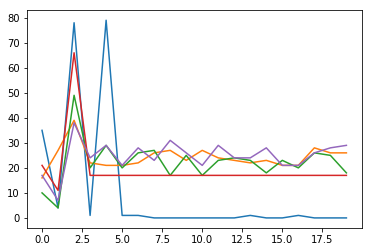

In [19]:
plt.plot(actions[:5].T)

In [20]:
with pm.Model() as model:
    explore = pm.Beta('explore', 1., 1.)
    obs = pm.Potential('obs', likelihood(X, ucb, {'explore': explore}, 1, [1.]))

In [21]:
with model:
    trace = pm.sample(600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [explore]
Sampling 4 chains: 100%|██████████| 4400/4400 [00:10<00:00, 422.54draws/s]
The acceptance probability does not match the target. It is 0.8812834431523555, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CF002016A0>,
      dtype=object)

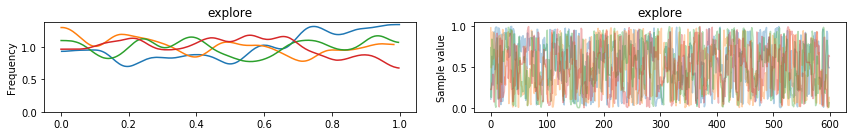

In [22]:
pm.traceplot(trace)

In [23]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = 0.069682, ||grad|| = 5.014e-06: 100%|██████████| 12/12 [00:00<00:00, 523.74it/s]  


{'explore_logodds__': array(-10.68271241), 'explore': array(2.29375479e-05)}

In [24]:
print("p(X | pure explore) = " + str((likelihood(X, ucb, {'explore': 1.}, 1, [1.]))))
print("p(X | explore/exploit) = " + str((likelihood(X, ucb, {'explore': .5}, 1, [1.]))))
print("p(X | pure exploit) = " + str((likelihood(X, ucb, {'explore': .0}, 1, [1.]))))

p(X | pure explore) = 0.01036658431481957
p(X | explore/exploit) = 0.023026967451668302
p(X | pure exploit) = 0.06968698366297303


#### Mostly explore

In [32]:
X, clusters = generate(ucb, {'explore': [.9]}, neg_quad_kern, neg_quad, 20, 60, 1, [1.])
actions = X[:,:,2].argmax(axis = 2)

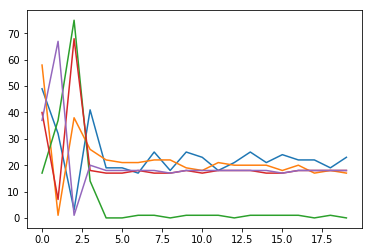

In [33]:
plt.plot(actions[:5].T)

In [34]:
with pm.Model() as model:
    explore = pm.Beta('explore', 1., 1.)
    obs = pm.Potential('obs', likelihood(X, ucb, {'explore': explore}, 1, [1.]))

In [35]:
with model:
    trace = pm.sample(600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [explore]
Sampling 4 chains: 100%|██████████| 4400/4400 [00:10<00:00, 431.61draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CF01835278>,
      dtype=object)

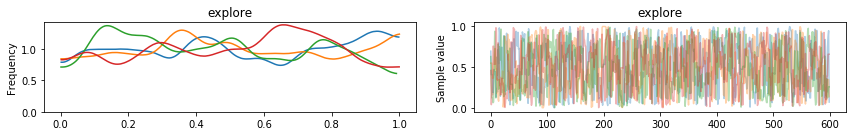

In [36]:
pm.traceplot(trace)

In [37]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = 0.025017, ||grad|| = 0.0022876: 100%|██████████| 5/5 [00:00<00:00, 502.58it/s]


{'explore_logodds__': array(-21.), 'explore': array(7.58256042e-10)}

In [38]:
print("p(X | pure explore) = " + str((likelihood(X, ucb, {'explore': 1.}, 1, [1.]))))
print("p(X | explore/exploit) = " + str((likelihood(X, ucb, {'explore': .5}, 1, [1.]))))
print("p(X | pure exploit) = " + str((likelihood(X, ucb, {'explore': .0}, 1, [1.]))))

p(X | pure explore) = 0.02261614024238117
p(X | explore/exploit) = 0.025017497246337173
p(X | pure exploit) = 0.07330644938587792


#### Mostly exploit

In [39]:
X, clusters = generate(ucb, {'explore': [.1]}, neg_quad_kern, neg_quad, 20, 60, 1, [1.])
actions = X[:,:,2].argmax(axis = 2)

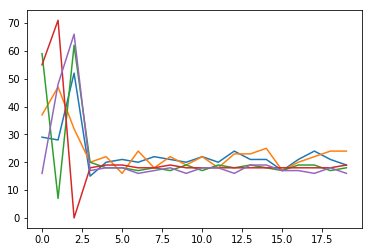

In [40]:
plt.plot(actions[:5].T)

In [41]:
with pm.Model() as model:
    explore = pm.Beta('explore', 1., 1.)
    obs = pm.Potential('obs', likelihood(X, ucb, {'explore': explore}, 1, [1.]))

In [42]:
with model:
    trace = pm.sample(600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [explore]
Sampling 4 chains: 100%|██████████| 4400/4400 [00:10<00:00, 420.69draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CF0078F4E0>,
      dtype=object)

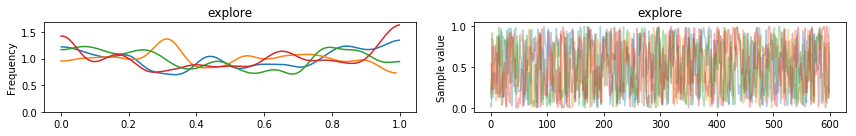

In [43]:
pm.traceplot(trace)

In [44]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = 0.026682, ||grad|| = 0.010003: 100%|██████████| 11/11 [00:00<00:00, 580.50it/s]


{'explore_logodds__': array(-11.44835726), 'explore': array(1.06668695e-05)}

In [45]:
print("p(X | pure explore) = " + str((likelihood(X, ucb, {'explore': 1.}, 1, [1.]))))
print("p(X | explore/exploit) = " + str((likelihood(X, ucb, {'explore': .5}, 1, [1.]))))
print("p(X | pure exploit) = " + str((likelihood(X, ucb, {'explore': .0}, 1, [1.]))))

p(X | pure explore) = 0.015124318295714029
p(X | explore/exploit) = 0.026682116840222318
p(X | pure exploit) = 0.10105842751379401
